# Project: Train a Quadcopter How to Fly

We design an agent to fly a quadcopter, and then train it using a DDPG reinforcement learning algorithm! 


## Instructions

Description of the files in the directory to better understand the structure of the project. 

- `task.py`: Contains the definition of our task (environment).
- `agents/`: The folder containing reinforcement learning agents.
    - `policy_search.py`: Contains a sample agent.
    - `agent.py`: We developped our agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, we will define our own task in `task.py`. Later in this notebook, we will amend this file.

We will also design a reinforcement learning agent in `agent.py` to complete our chosen task.  

## Controlling the Quadcopter

There is a sample agent in the code showing how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that we'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that we will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [37]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

The code cell below allows us to have the agent select actions to control the quadcopter.  

We can change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modifying the values below to give the quadcopter a different starting position.
runtime = 3.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 10])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Running the simulation, and saving the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Running the code cell below to visualize how the position of the quadcopter evolved during the simulation.

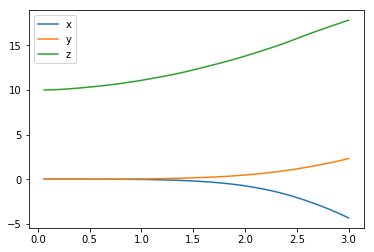

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

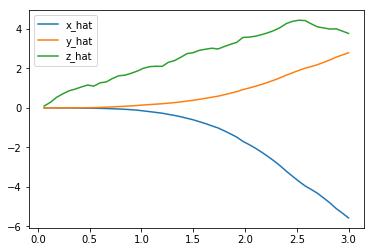

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, we can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

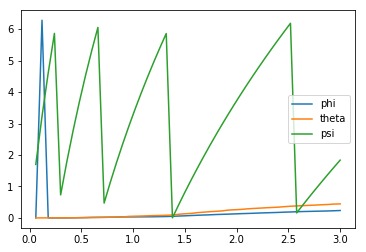

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

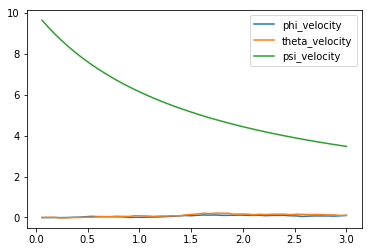

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, we can use the code cell below to print the agent's choice of actions.  

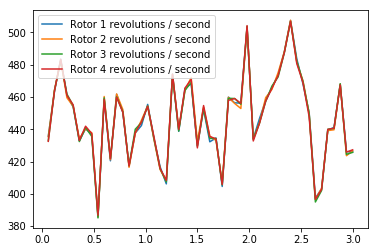

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, we will derive the environment state from the simulator.  Running the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ -4.34253656   2.30253166  17.81337927   0.235563     0.44612457
   1.83643157]
[-5.57281859  2.79040666  3.76592589]
[ 0.09834627  0.10380202  3.47106357]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for our purposes, we can expand the size of the state vector by including the velocity information.  We can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit our task.

## The Task

`task.py`, is a sample task.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If we are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). We can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends. We can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, we will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Running the code cell below, we'll see how the agent performs on the sample task.

In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
#from agents.agent import DDPG
from task import Task

num_episodes = 500
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 
#agent = DDPG(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =  500, score =   0.018 (best =   0.308), noise_scale = 3.255

This agent should perform very poorly on this task.  And that's where we come in!

## Defining the Task, Designing the Agent, and Training our Agent!

We'll amend `task.py` to specify a task of our choosing.  If we're unsure what kind of task to specify, we may like to teach our quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying our task, we use the sample agent in `agents/policy_search.py` as a template to define our own agent in `agents/agent.py`.  We can borrow whatever we need from the sample agent, including ideas on how we might modularize our code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that we specify will learn well.  We will likely have to tweak various hyperparameters and the reward function for our task until we arrive at reasonably good behavior.

As we develop our agent, it's important to keep an eye on how it's performing. We use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that our agent is learning.

In [ ]:
## Training our agent.

import  sys
from agents.agent import DDPG
from task import Task
from task import TakeOffTask
import numpy as np

init_pose = np.array([0., 0., 100., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

num_episodes = 1000
target_pos = np.array([0., 0., 100.])
task = TakeOffTask(target_pos=target_pos)
agent = DDPG(task) 

avg_episode_rewards = []
episode_rewards = []

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        if done:
            avg_episode_rewards.append(agent.score)
            episode_rewards.append(agent.total_reward)
            print("\rEpisode = {:4d}, avg_reward = {:7.3f}, reward = {:7.3f}".format(i_episode, agent.score, agent.total_reward), end="")
            break
    sys.stdout.flush()

Episode =  108, avg_reward =  -2.817, reward = -202.846

## Plot the Rewards

Once we are satisfied with our performance, we plot the episode rewards, either from a single run, or averaged over multiple runs. 

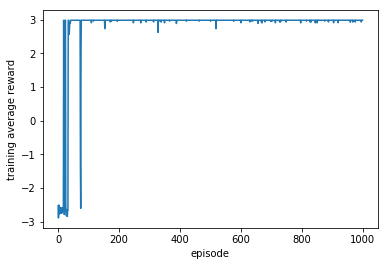

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(avg_episode_rewards)
plt.xlabel('episode')
plt.ylabel('training average reward')


plt.show()

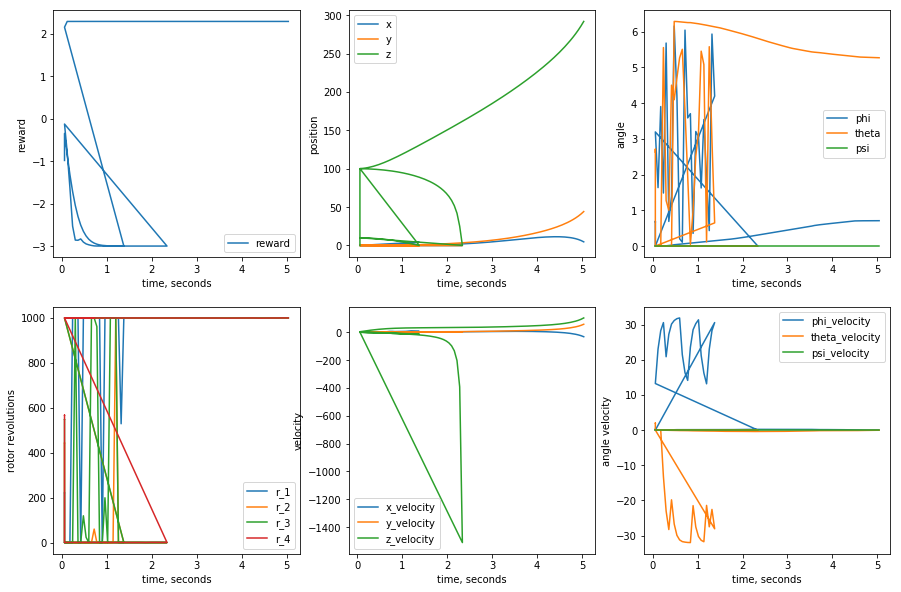

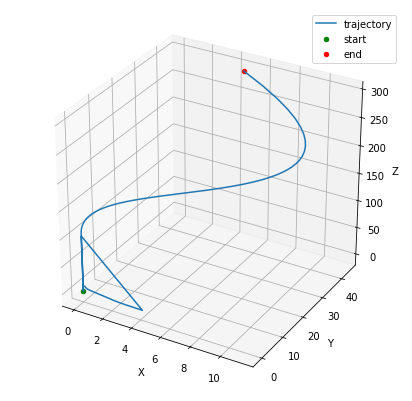

Start coordinates: x=  0.009 y=  0.000 z=  0.000
End coordinates: x=  4.643 y= 44.114 z=291.873


In [53]:
from agents.Plotter import Plotter
state = agent.reset_episode() # starting a new episode
# plotter = Plotter()

while True:
    action = agent.act(state) 
    next_state, reward, done = task.step(action)
    
    # logging
    data_to_log = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward]
    plotter.add(data_to_log)
    
    agent.step(action, reward, next_state, done, is_learning=False)
    state = next_state
    if done:
        break
        
plotter.plot_all()
plotter.plot_trajectory()

## Reflections
The task we specified is for the quadcopter to fly vertically upward.

1 - .3*(abs(self.sim.pose[2] - self.target_pos[2])).sum() is te z position reward. self.sim.pose[2] is the agent’s position value in the simulator at z-direction. self.target_pos[2] is the target position value at z-direction. If the difference between these 2 variable values increases, rewards will go down and may become negative. Therefore we want the agent’s position value in the simulator to be as close as the target position for the rewards to be positive.

We designed the reward function as the self.sim.v[2] and applied np.tanh around it so that the reward values stay bounded in (-1,1). In this way, the agent will be rewarded some proportion of self.sim.v[2] by flying upwards at z-direction. We don't think that we are doing this in a good way since our rewards are beyond (-1,1).

reward=np.tanh(self.sim.v[2])
Because of the above line of code, the agent is flying beyond the target position. 

We sticked to DDPG algorithm... 
We have experimented with the suggested architectures in the example code. The actor's network has 3 fully connected (FC) layers with 32, 64 and 32 units respectively followed by a FC layer with unit number equals to action space, followed each with a batch normalization layer as well as a relu activation function. The critic network has both state and action as an input. State input is fed into two FC layers with 32 and 64 units. The next layer sums the two small NN together. The critic's final layer is a FC layer which has 1 unit and it outputs an estimated Q-value. Adam optimization algorithm was used with a learning rate of $10^{-5}$ and $10^{-3}$ for actor and critic respectively. The layers were initialized using Xavier initialization except the final layers. The final layers were initialized from a uniform distribution $[10^{-5}, 10^{5}]$ for actor and $[10^{-3}, 10^{3}]$ for critic. Both NNs used $L_1$ regularization with weight decay of $10^{-3}$. The discount factor $\gamma$ was chosen to be $0.99$ and for the soft update $\tau=0.0001$ was used. The NNs were trained using minibatches of size $64$ and a replay buffer of size $10^4$. For exploration purposes an Ornstein-Uhlenbeck process with $\mu=0$, $\theta=0.01$ and $\sigma=0.01$ was used.

We think that the task is hard because it requires a large in magnitude action which should be balanced among all 4 rotors. We made a lot of simulations and for the last one, it seems that it only took less than 100 episodes for the agent to figure out the best strategy.

We have got a lot of different curves and some of them were stuck in a local minimum reporting the worst possible reward. The one presented in the report the best one I have got.

The hardest part in the project was and still is definitely making the training work. It seems that for our last try, our agent is learning better. Getting started was a huge challenge. We needed to understand the entire architecture of the project, before digging in. 

The other hard part of the project was inconsistent training. 


Bibligraphy:
https://github.com/SergeyPoltavtsev/Quadcopter-RL
https://discussions.udacity.com/t/i-cannot-plot-the-rewards-after-traine-the-agent/695877/5
https://discussions.udacity.com/t/recurring-error-in-quadcopter-training-home-workspace-physics-sim-py-runtimewarning-overflow-encountered/782700
https://discussions.udacity.com/t/i-cannot-plot-the-rewards-after-traine-the-agent/695877/5
https://discussions.udacity.com/t/how-to-specify-a-task/640350/7
https://discussions.udacity.com/t/some-doubts-about-the-version-2-of-the-project/637475/17
https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html
https://discussions.udacity.com/t/quadcopter-crushing-down/651985/12